In [1]:
%load_ext autoreload
%autoreload 2
import param_tool as pt
import os 
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
import sys
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdFMCS
from typing import Callable
import psiresp
import nglview as nv
import MDAnalysis as mda
import glob

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output

IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = (600, 400)

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(
/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(


In [2]:
!pwd

/home/_shared/_projects/2022_md_FRET_nv/param_R_CIT


# Протокол расчета парциальных зарядов для модифицированных аминокислот
На вход подаються .smi-файлы мономера и полимеров аминокислоты, где аминокислота входит в состав полимера в положениях N M C. 
У мономера должны бать группы COO<sup>-</sup> и N<sup>+</sup>H<sub>3</sub>. У полимеров соответствующие группы на С и N концах.  

## Пример загрузки и отображения молекулы 

In [51]:
R_smi = pt.read_file('moleculse/R.smiles')
R_CIT_smi = pt.read_file('moleculse/R_CIT.smiles')
R_chem = pt.smi_to_chem(R_smi, make_N_root=True)
R_CIT_chem = pt.smi_to_chem(R_CIT_smi, make_N_root=True)

atom number: 0 became the root atom: 0
atom number: 11 became the root atom: 0


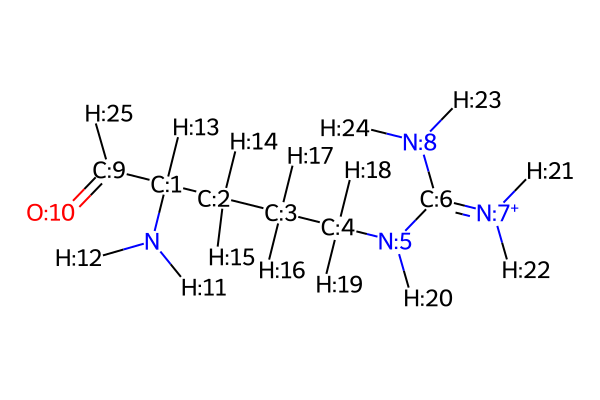

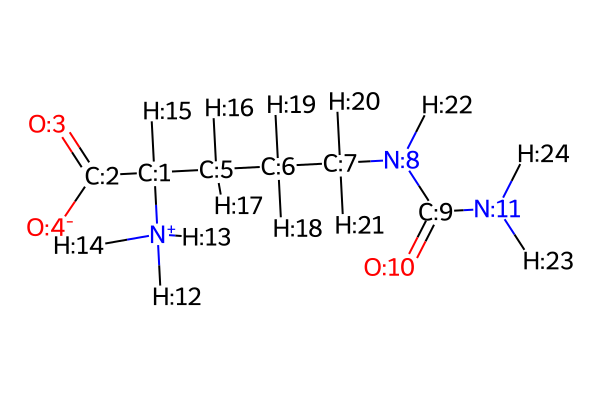

In [28]:
display(pt.draw_mol_with_atom_index(R_chem['R']))
display(pt.draw_mol_with_atom_index(R_CIT_chem['R_CIT']))

## Шаг 1 Открытие .smi-файлов 
Мы рекомендуем использовать словари для записи фаилов молекул, также можно передать путь к  `.smi` в виде строки или листа. На выход вы получите словарь с соответствующими ключами. 

In [250]:
monomer_smi = pt.read_file('moleculse/R_CIT.smiles')
trimers_smi = pt.read_file([
                            # 'moleculse/RA_CIT.smiles', 
                            # 'moleculse/GRG_CIT.smiles',
                            # 'moleculse/GR_CIT.smiles',
    
                            'moleculse/RGG_CIT.smiles',
                            'moleculse/GRG_CIT.smiles',
                            'moleculse/GGR_CIT.smiles'
                           ])
monomer_chem = pt.smi_to_chem(monomer_smi, make_N_root=False) # RDKit читает smi строку, переводит в chem и добавляет протоны
trimers_chem = pt.smi_to_chem(trimers_smi)
trimers_chem

{'RGG_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdfa40361c0>,
 'GRG_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdeed93df40>,
 'GGR_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdeeda69520>}

## Шаг 2 Поиск подструктур мономера а.к. в полмерах
Наша задача выделить те атомы в составе полимеров, которые входят в состав мономера. Для этого функция `match_mon_to_pol` принимает на вход пару словарей с `Chem` фаилами. Словарь мономеров (один мономер) и полимеров (от 1 до ∞) соответственно. На выход подается словарь с ключами: `substructure`, `mon_pol_matches`, для кажого из полимеров. \
Где:
- `substructure` - сожердит общие подструктуры мономера и полимера, для каждого из полимеров в формате Chem .
- `mon_pol_matches` - содержит словари соответствия номеров атомов в общей подструктуре с номерами атомов в полимере молекула из общей подструктуры.\
(обычно вам не понадобится этот ключ, но он используется для подсвечивания общей структуры полимера на мономере)

Обратите внимание что набор атомов подструктур внутри мономера различается в зависимости от расположения а.к. в полимере

In [251]:
match_dict = pt.match_mon_to_pol(monomer_chem, trimers_chem, compare_any_bond = False)

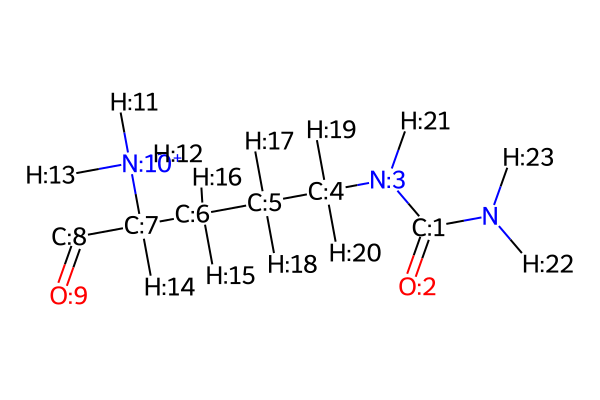

In [252]:
pt.draw_mol_with_atom_index(match_dict['substructure']['RGG_CIT'])

In [5]:
match_dict.keys()

dict_keys(['substructure', 'mon_pol_matches', 'N_match_atoms'])

In [6]:
match_dict['substructure']

{'RGG_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdfa890fd60>,
 'GRG_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdfa4028940>,
 'GGR_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdfa40288e0>}

### Отрисовка полученных подструктур на молекулах мономера и полимера
Позволяет убедится в корректности структур

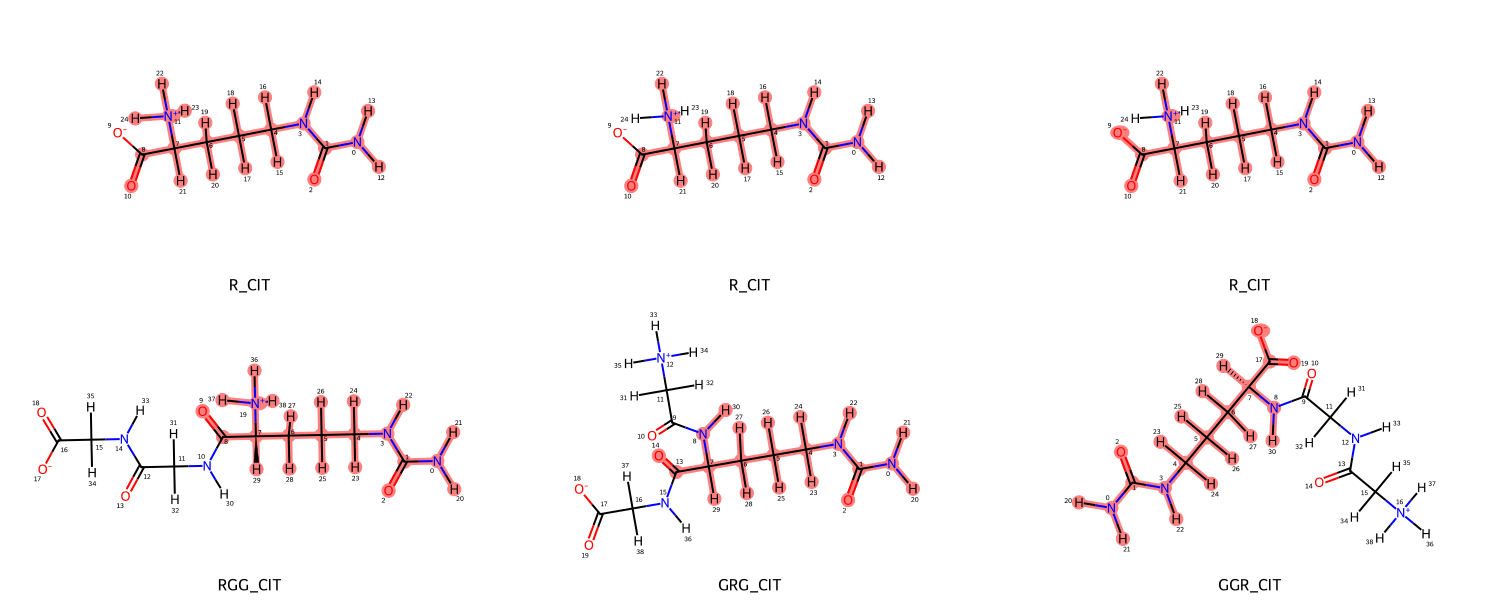

In [253]:
pt.draw_mon_pol_match(monomer_chem, trimers_chem, match_dict, add_small_atom_index=True)

## Шаг 3 Поиск подбор имен атомов из набора стандартных аминокислот

Полученные подструктуры на предыдущем шаге представляют собой модели молекул модифицированных аминокислот для каждого из положений:
- N-end
- inter
- C-end

__Задача:__ 

Необходимо для каждой из этих структур сохранить файлы в следующих форматах:

- `.smi`
- `.pdb`

Для сохранения .pdb файлов требуется:

- Получить имена атомов, используемые в стандартной версии аминокислоты.
- Убедиться, что в структуре правильно заданы типы связей и идентификаторы атомов.

__Результатом выполнения данного шага являются:__

Файлы .smi, соответствующие сохранённым структурам.
Файлы .pdb с корректными именами атомов и типами связей.

#### Сохранение подструктур в виде **smiles**

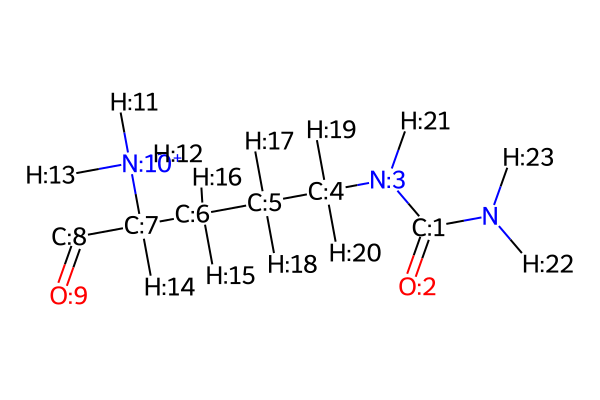

In [8]:
pt.draw_mol_with_atom_index(match_dict['substructure']['RGG_CIT'])

In [307]:
sub_name = ['NR_CIT', 'R_CIT', 'CR_CIT']
for chem_name, chem_mol in zip(sub_name, match_dict['substructure'].values()):
    pt.save_aa_chem_to_smiles(chem_mol, f'moleculse/mod_aa/{chem_name}',make_N_root=True)

atom number: 10 became the root atom: 0
NR_CIT.smiles saved to moleculse/mod_aa
atom number: 10 became the root atom: 0
R_CIT.smiles saved to moleculse/mod_aa
atom number: 11 became the root atom: 0
CR_CIT.smiles saved to moleculse/mod_aa


##### Проверка сохраненных подструктур

In [308]:
test_smi = pt.read_file(['moleculse/mod_aa/NR_CIT.smiles',
              'moleculse/mod_aa/R_CIT.smiles',
              'moleculse/mod_aa/CR_CIT.smiles'])
test_chem = pt.smi_to_chem(test_smi, addH=False, sanitize=False)
IPythonConsole.drawOptions.addAtomIndices = False

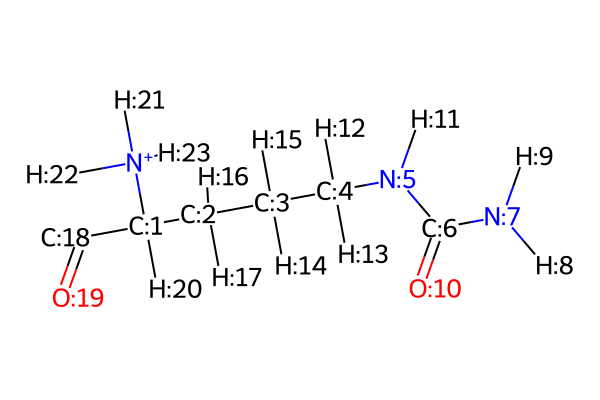

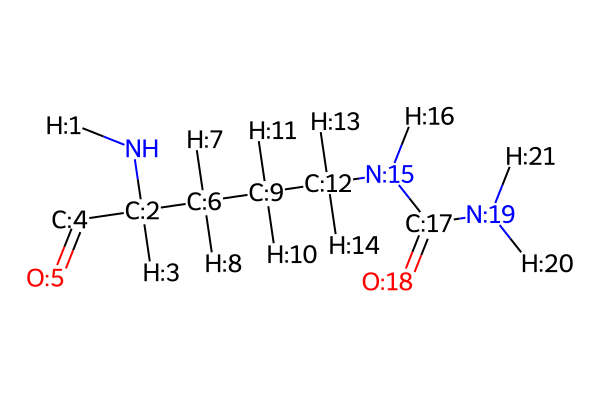

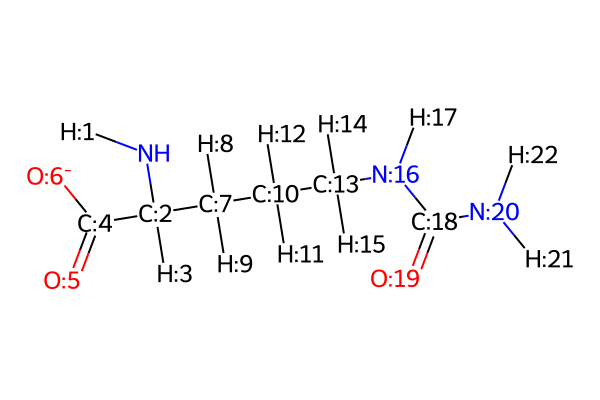

In [309]:
display(pt.draw_mol_with_atom_index(test_chem['NR_CIT']))
display(pt.draw_mol_with_atom_index(test_chem['R_CIT']))
display(pt.draw_mol_with_atom_index(test_chem['CR_CIT']))

### Сохранение подструктур в виде **pdb**

То как выглядит подструктура для одного из вариантов позиционирования остатка в цепи:

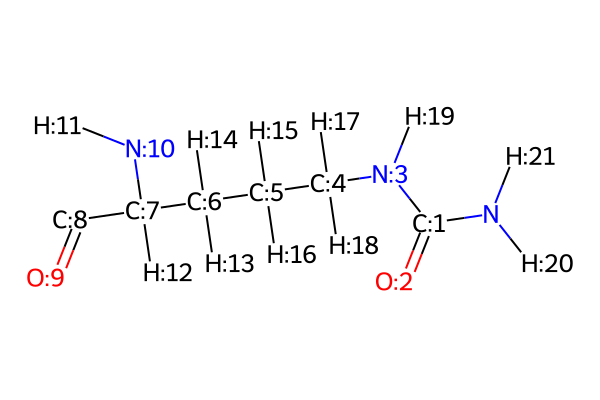

In [14]:
pt.draw_mol_with_atom_index(match_dict['substructure']['GRG_CIT'])

Сохранение подструктуры (т.е. атомов входящих в состав модифицированного остатка в зависимости от его позиции в полимере) в формате 
`pdb`. \
Далее полученные ДНК используются для получения парциальных зарядов и для получения файлов топологии. \
Кроме этого вы можете взять их и использовать в молекулярном  моделировании для добавления модифицированного остатка в вашу структуру.   

##### Одиночное сохранение:

In [16]:
pt.save_aa_chem_to_pdb(match_dict['substructure']['GRG_CIT'], 
                       f'moleculse/substructure/R_CIT', 
                       resname = 'R_C', 
                       resid= 1,
                       segid= 'A',
                       make_N_root=True)

atom number: 10 became the root atom: 0
Длина atom_names_list не совпадает с количеством атомов в rdkit_mol. Будут использованы стандартные имена атомов.
R_CIT.pdb saved to moleculse/substructure


/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(
[16:11:13] Molecule does not have explicit Hs. Consider calling AddHs()
[16:11:13] Molecule does not have explicit Hs. Consider calling AddHs()


##### Множественное сохранение:

In [17]:
sub_name = ['NR_CIT', 'R_CIT', 'CR_CIT']
resname_l = ['NRC', 'RC', 'CRC']
for chem_name, chem_mol, resname in zip(sub_name, match_dict['substructure'].values(), resname_l):
    pt.save_aa_chem_to_pdb(chem_mol, f'moleculse/substructure/{chem_name}', resname = resname, make_N_root=True)

atom number: 10 became the root atom: 0
Длина atom_names_list не совпадает с количеством атомов в rdkit_mol. Будут использованы стандартные имена атомов.
NR_CIT.pdb saved to moleculse/substructure
atom number: 10 became the root atom: 0
Длина atom_names_list не совпадает с количеством атомов в rdkit_mol. Будут использованы стандартные имена атомов.
R_CIT.pdb saved to moleculse/substructure
atom number: 11 became the root atom: 0
Длина atom_names_list не совпадает с количеством атомов в rdkit_mol. Будут использованы стандартные имена атомов.
CR_CIT.pdb saved to moleculse/substructure


[16:11:17] Molecule does not have explicit Hs. Consider calling AddHs()
[16:11:17] Molecule does not have explicit Hs. Consider calling AddHs()
[16:11:17] Molecule does not have explicit Hs. Consider calling AddHs()
[16:11:17] Molecule does not have explicit Hs. Consider calling AddHs()


#### Проверка сохраненных молекул

In [18]:
test_pdb = pt.pdb_to_chem([
              'moleculse/substructure/NR_CIT.pdb',
              'moleculse/substructure/R_CIT.pdb',
              'moleculse/substructure/CR_CIT.pdb',
              
                        ])

# IPythonConsole.drawOptions.addAtomIndices = False
test_pdb

{'NR_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdf63cbbdc0>,
 'R_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdf69c7eca0>,
 'CR_CIT': <rdkit.Chem.rdchem.Mol at 0x7fdf69c7ea60>}

Если все получилось, то вы молжны получить картинку тогоже остатка с такимиже типами связей и количеством атомов. \
В случае если вы использовали `make_N_root=True` последовательность нумерации атомов должна была поменяться и нулевым атомом должен был стать `N` в аминогруппе

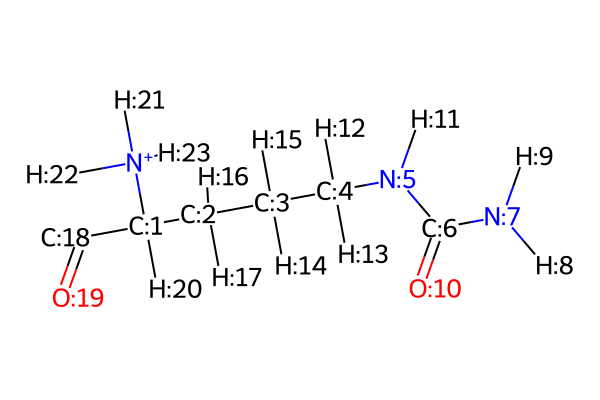

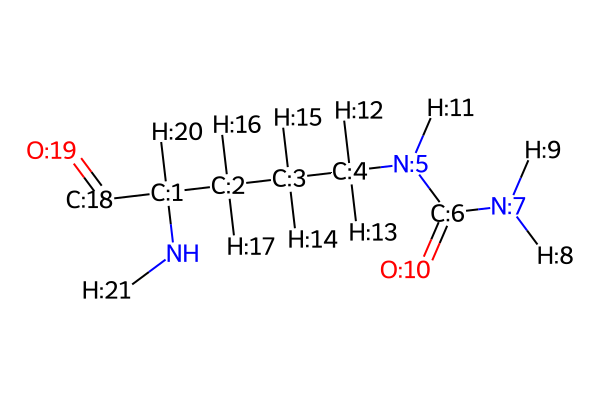

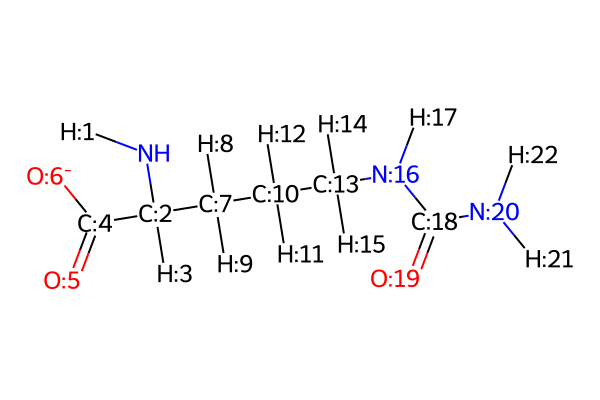

In [19]:
display(pt.draw_mol_with_atom_index(test_pdb['NR_CIT']))
display(pt.draw_mol_with_atom_index(test_pdb['R_CIT']))
display(pt.draw_mol_with_atom_index(test_pdb['CR_CIT']))

##### NGLview отрисовка

Поскольку мы сохранили pdb фаил то можно и через MDAnalysis и nglview посмотреть на него

In [4]:
nv.show_mdanalysis(mda.Universe('moleculse/substructure/NR_CIT_1_rdkit.pdb'))

NGLWidget()

#### Переименовываем атомы в модифицированных аминокислотах исходя из их имен в стандартных аминокислотах 

Пример для одной молекулы

In [30]:
# Используем промежуточный pdb файл из substructure для сопоставления с стандартными аминокислотами 
path_to_mod_aa_dict = 'moleculse/substructure/R_CIT.pdb'
mod_aa_chem_dict = pt.pdb_to_chem(path_to_mod_aa_dict)
ref_aa_chem_dict = pt.pdb_to_chem(glob.glob('moleculse/aminoacids_template/*'))
match_data_dict = pt.match_mon_to_pol(mod_aa_chem_dict, ref_aa_chem_dict)



In [21]:
# Можно сделать чтобы для максимального сопоставлени ястроился матч тогда будут созранены хайлайты на структурах от него 
# Либо строить сопоставление всех матчей, но это много... 20 АК...  

21
RRR
 R_CIT has max matches atoms (21) with RRR amino acids 


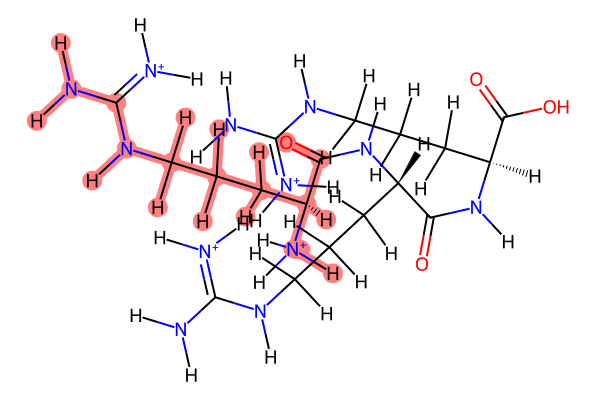

In [39]:
# Выявление остатка с которым наибольшая общая подструктура 
name, chem = next(iter(mod_aa_chem_dict.items()))
max_key = max(match_data_dict['N_match_atoms'])

ref_aa_name = match_data_dict['N_match_atoms'][max_key]

print(f" {name} has max matches atoms ({max_key}) with {ref_aa_name} amino acids ")
ref_aa_chem_dict[ref_aa_name]

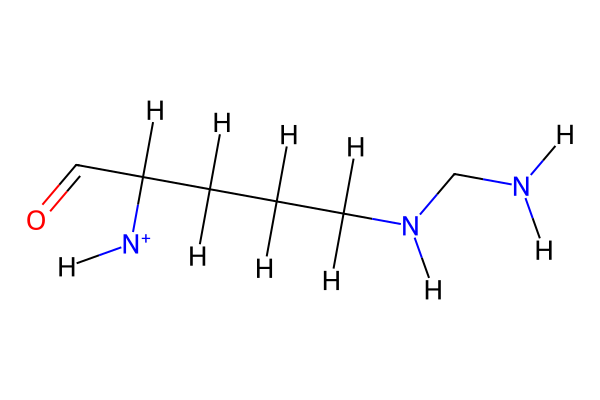

In [32]:
match_data_dict['substructure']['RRR']

In [63]:
mod_universe_mda = mod_aa_chem_dict['R_CIT']
ref_universe_mda = ref_aa_chem_dict[ref_aa_name]
dict_mol1_mol2_matches = match_data_dict['mon_pol_matches'][ref_aa_name]

# mod_universe_mda = mda.Universe('moleculse/substructure/R_CIT.pdb')
# ref_universe_mda = mda.Universe(f'moleculse/aminoacids_template/{ref_aa_name}.pdb')

test_mod = pt.generate_atom_names_by_ref_aa( mod_universe_mda, ref_universe_mda, 
                                            dict_mol1_mol2_matches, output_path='moleculse/mod_aa/R_CIT.pdb')

['N', 'C', 'C', 'C', 'C', 'N', 'C', 'N', 'H', 'H', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'C', 'O', 'H', 'H']
Переименовываем 0:N -> 0:N1
(0:N) -> (0:N)
(1:C) -> (1:CA)
(2:C) -> (4:CB)
(3:C) -> (5:CG)
(4:C) -> (6:CD)
(5:N) -> (7:NE)
(6:C) -> (8:CZ)
(7:N) -> (9:NH1)
(8:H) -> (19:HH11)
(9:H) -> (20:HH12)
(11:H) -> (18:HE)
(12:H) -> (16:HD2)
(13:H) -> (17:HD3)
(14:H) -> (14:HG2)
(15:H) -> (15:HG3)
(16:H) -> (12:HB2)
(17:H) -> (13:HB3)
Переименовываем 18:C -> 18:C1
(18:C) -> (2:C)
Переименовываем 19:O -> 19:O1
(19:O) -> (3:O)
(20:H) -> (11:HA)
(21:H) -> (23:H1)
Все имена атомов уникальны.


In [64]:
test_mod

['N',
 'CA',
 'CB',
 'CG',
 'CD',
 'NE',
 'CZ',
 'NH1',
 'HH11',
 'HH12',
 'O1',
 'HE',
 'HD2',
 'HD3',
 'HG2',
 'HG3',
 'HB2',
 'HB3',
 'C',
 'O',
 'HA',
 'H1']

In [65]:
pt.save_aa_chem_to_pdb(match_dict['substructure']['GRG_CIT'], 
                       f'moleculse/mod_aa/R_CIT', 
                       resname = 'R_C', 
                       resid= 1,
                       segid= 'A',
                       make_N_root=True,
                      atom_names_list = test_mod)

atom number: 10 became the root atom: 0
R_CIT.pdb saved to moleculse/mod_aa


/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(
[16:42:01] Molecule does not have explicit Hs. Consider calling AddHs()
[16:42:01] Molecule does not have explicit Hs. Consider calling AddHs()


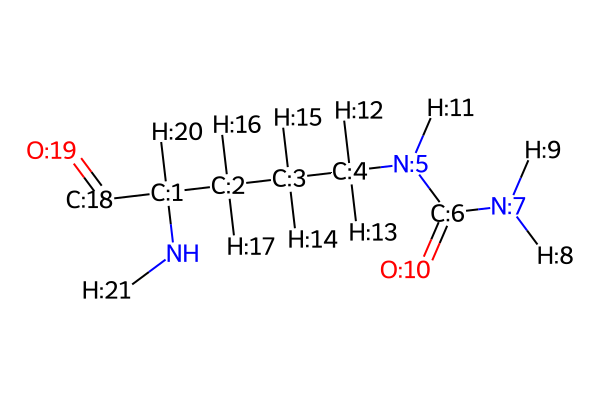

In [66]:
test_pdb = pt.pdb_to_chem([
              # 'moleculse/substructure/NR_CIT.pdb',
              'moleculse/mod_aa/R_CIT.pdb',
              # 'moleculse/substructure/CR_CIT.pdb',
                        ])
display(pt.draw_mol_with_atom_index(test_pdb['R_CIT']))
# display(pt.draw_mol_with_atom_index(test_pdb['R_CIT']))
# display(pt.draw_mol_with_atom_index(test_pdb['CR_CIT']))

Из молекулы мономера были выделены структуры аминокислот для каждой из позиций `N` `M` `C`. Важно ответить, что при созранение подструктур идет переупордочивание атомов таким образом, что первым атомом в молекуле становится автом **N** в составе аминогруппы. Далее имено они будут использоваться при получении файлов топологии. \
Ниже представленно несколько вариантов сохранения подструктур, но в итоге будут использоватсья файлы формата `.pdb` 

Были получены молекулярные формулы параметризируемых остатков `match_dict['substructure']`. Именно они будут использоваться для получения фаилов топологии в следующем ноутбуке.

## Расчет зарядов при помощи библиотеки psiresp

На вход: 
- Молекула-ы в виде тримеров в формате smiles. 

Задача ограничейни зарядов для одной молекулы
Словарь собранный для каждой молекулы полимера. Для каждого полимера он свой.
Задача ограничений зарядов для набора молекул
При растчете зарядов для нескольких молекул одновременно constraints теряются и не учитываются при расчетах. 
Так же теряется симетрия атомов. В связи с этим при использовании psiresp будут проводится расчеты для одной молекулы за раз. 



Создание ограничений

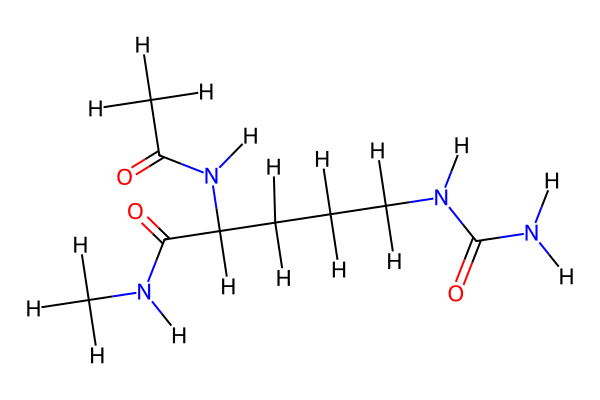

In [121]:
ttt = pt.read_file('moleculse/sRs_CIT.smiles')
ttt_chem = pt.smi_to_chem(ttt)
ttt_chem['sRs_CIT']

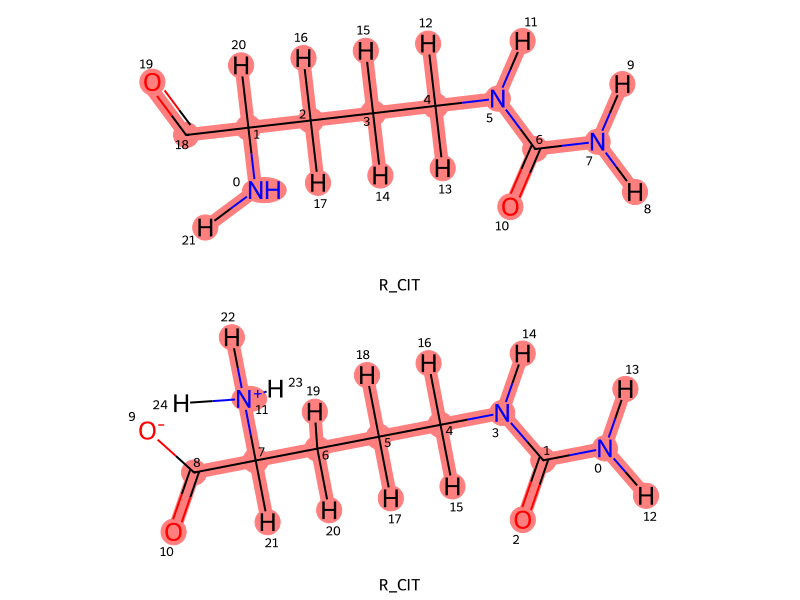

In [234]:
monomer_chem = pt.pdb_to_chem([
              # 'moleculse/substructure/NR_CIT.pdb',
              'moleculse/mod_aa/R_CIT.pdb',
              # 'moleculse/substructure/CR_CIT.pdb',
                        ])
trimers_smi = pt.read_file([
                            'moleculse/R_CIT.smiles'
                            # 'moleculse/RA_CIT.smiles', 
                            # 'moleculse/GRG_CIT.smiles',
                            # 'moleculse/GR_CIT.smiles',
                            # 'moleculse/RGG_CIT.smiles',
                            # 'moleculse/sRs_CIT.smiles'
                            # 'moleculse/GRG_CIT.smiles',
                            # 'moleculse/ARV_CIT.smiles'
                            # 'moleculse/GGR_CIT.smiles'
                           ])
# monomer_chem = pt.smi_to_chem(monomer_smi, make_N_root=False) # RDKit читает smi строку, переводит в chem и добавляет протоны
trimers_chem = pt.smi_to_chem(trimers_smi)
trimers_chem

match_dict = pt.match_mon_to_pol(monomer_chem, trimers_chem, compare_any_bond = False)
pt.draw_mon_pol_match(monomer_chem, trimers_chem, match_dict, add_small_atom_index=True, img_size=(800,300))

In [237]:
constraint_dict = {'NR_CIT':
                  {'symmetric_list': [],
                   'charge_atom_dict': {16: 0.1305, 32:0.2083, 33:0.2083, 34:0.2083, 7:-0.0223, 26:0.1242, 8:0.7214, 9:-0.6013},
                   'charge_of_monomer': 0.0000,
                  },
                   'R_CIT':
                  {'symmetric_list': [[12,13], [15,16], [17,18], [19,20]],
                    'charge_atom_dict': {11:-0.34790, 22:0.2747, 7:-0.2637, 21:0.1560, 8:0.7341, 10:-0.5894},
                    'charge_of_monomer': 0.0000,
                  },
                  #  'RA_CIT':
                  # {'symmetric_list': [[17,18], [20,21], [22,23], [24,25], [32,33,34]],
                  #  'charge_atom_dict': {16: 0.1305, 32:0.2083, 33:0.2083, 34:0.2083, 7:-0.0223, 26:0.1242, 8:0.7214, 9:-0.6013},
                  #  'charge_of_monomer': 1.0000,
                  # },
                   'RGG_CIT':
                  {'symmetric_list': [],
                   'charge_atom_dict': {19: 0.1305, 36:0.2083, 37:0.2083, 38:0.2083, 7:-0.0223, 29:0.1242, 8:0.7214, 9:-0.6013},
                   'charge_of_monomer': 1.0000,
                  },
                   'sRs_CIT':
                  {'symmetric_list': [[16,17], [19,20], [21,22], [23,24]],
                    'charge_atom_dict': {8:-0.34790, 26:0.2747, 7:-0.2637, 25:0.1560, 12:0.7341, 13:-0.5894},
                    'charge_of_monomer': 0
                  },
                   'ARV_CIT':
                  {'symmetric_list': [[35,36], [37,38], [39,40], [42,43]],
                    'charge_atom_dict': {8:-0.34790, 28:0.2747, 7:-0.2637, 27:0.1560, 5:0.7341, 6:-0.5894},
                    'charge_of_monomer': 0.0000
                  },
                  #   'RGG_CIT':
                  # {'symmetric_list': [[21,20], [24,23], [26,25], [28,27], [36,37,38]],
                  #  'charge_atom_dict': {19: 0.1305, 36:0.2083, 37:0.2083, 38:0.2083, 7:-0.0223, 29:0.1242, 8:0.7214, 9:-0.6013},
                  #  'charge_of_monomer': 1.0000,
                  # },
                   'GRG_CIT':
                   {'symmetric_list': [[21,20], [24,23], [26,25], [28,27]],
                    'charge_atom_dict': {8:-0.34790, 30:0.2747, 7:-0.2637, 29:0.1560, 13:0.7341, 14:-0.5894},
                    'charge_of_monomer': 0.0000
                   },
                    'GR_CIT':
                   {'symmetric_list': [[16,17], [19,20], [21,22], [23,24], [14,15]],
                    'charge_atom_dict': {8:-0.34790, 26:0.2764, 7:-0.3068, 25:0.1447, 13:0.8557, 14:-0.8266, 15:-0.8266},
                    'charge_of_monomer': -1.0000
                   },
                   'GGR_CIT':
                   {'symmetric_list': [ [21,20], [24,23], [26,25], [28,27], [19,18] ],
                    'charge_atom_dict': {8:-0.34790, 30:0.2764, 7:-0.3068, 29:0.1447, 17:0.8557, 18:-0.8266, 19:-0.8266},
                    'charge_of_monomer': -1.0000
                   }
                  }

In [238]:
# psiresp_dict, constraints = pt.prepere_constraints('RA_CIT', trimers_chem , match_dict, 
#                                                    constraint_dict, 
#                                                    conformer_generation_options = dict(n_conformer_pool=1000,
#                                                             n_max_conformers=1, energy_window = 100, 
#                                                             keep_original_conformer=False))

In [240]:
param_mol_name = 'R_CIT'
psiresp_dict = {}
RESP_mol= psiresp.Molecule.from_rdkit(trimers_chem[param_mol_name],
                                      optimize_geometry = True, charge=0, 
                                      conformer_generation_options = dict(n_conformer_pool=10000, 
                                      n_max_conformers=4, energy_window = 30, keep_original_conformer=False))
psiresp_dict[param_mol_name] = RESP_mol
constraints = psiresp.ChargeConstraintOptions(symmetric_atoms_are_equivalent = False) # Если True, то сваливается в ошибку как не крути органичения :с 
constraints = pt.add_constraint(RESP_mol, 
                                constraint_dict[param_mol_name]['symmetric_list'] , 
                                constraint_dict[param_mol_name]['charge_atom_dict'], 
                                constraint_dict[param_mol_name]['charge_of_monomer'],
                                list(match_dict['mon_pol_matches'][param_mol_name].values()), 
                                constraints = constraints)

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(


In [ ]:
psiresp.Molecule.

In [241]:
list(match_dict['mon_pol_matches'][param_mol_name].values())

[11, 7, 6, 5, 4, 3, 1, 0, 12, 13, 2, 14, 15, 16, 17, 18, 19, 20, 8, 10, 21, 22]

In [242]:
constraints

ChargeConstraintOptions(charge_sum_constraints=[ChargeSumConstraint(atoms={Atom(index=11, molecule=Molecule(name=C6H13N3O3, charge=0) with 0 conformers)}, charge=-0.3479), ChargeSumConstraint(atoms={Atom(index=22, molecule=Molecule(name=C6H13N3O3, charge=0) with 0 conformers)}, charge=0.2747), ChargeSumConstraint(atoms={Atom(index=7, molecule=Molecule(name=C6H13N3O3, charge=0) with 0 conformers)}, charge=-0.2637), ChargeSumConstraint(atoms={Atom(index=21, molecule=Molecule(name=C6H13N3O3, charge=0) with 0 conformers)}, charge=0.156), ChargeSumConstraint(atoms={Atom(index=8, molecule=Molecule(name=C6H13N3O3, charge=0) with 0 conformers)}, charge=0.7341), ChargeSumConstraint(atoms={Atom(index=10, molecule=Molecule(name=C6H13N3O3, charge=0) with 0 conformers)}, charge=-0.5894)], charge_equivalence_constraints=[ChargeEquivalenceConstraint(atoms={Atom(index=12, molecule=Molecule(name=C6H13N3O3, charge=0) with 0 conformers), Atom(index=13, molecule=Molecule(name=C6H13N3O3, charge=0) with 0 c

In [243]:
psiresp_dict

{'R_CIT': Molecule(name=C6H13N3O3, charge=0) with 0 conformers}

### Расчет зарядов при помощи библиотеки psiresp

In [244]:
job = pt.resp_calculation(psiresp_dict, constraints, n_processes = 4)
monomer_charge_list = pt.make_substructure_charge_list(param_mol_name, job.molecules[0].charges, match_dict )
print(pt.calculate_true_sum(monomer_charge_list), monomer_charge_list ,sep='\n')

Новое имя директории: R_CIT


generate-conformers: 100%|██████████| 1/1 [01:21<00:00, 81.41s/it]


Колличество конформеров: 4
Выполнение run_optimization.sh.. 
run_optimization.sh выполнен успешно!
Время выполнения: 00:00:56


generating-orientations: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Выполнение run_single_point.sh.  
run_single_point.sh выполнен успешно!
Время выполнения: 00:00:32


compute-esp: 100%|██████████| 4/4 [00:00<00:00, 31.69it/s]


0.1174
[-0.3479 -0.2637  0.0035  0.0184 -0.0315 -0.5137  0.9799 -1.2514  0.4892
  0.4892 -0.6129  0.2741  0.0571  0.0571  0.0173  0.0173  0.08    0.08
  0.7341 -0.5894  0.156   0.2747]


In [175]:
job.molecules

[Molecule(name=C9H18N4O3, charge=0) with 4 conformers]

0.1174
[-0.3479 -0.2637  0.0035  0.0184 -0.0315 -0.5137  0.9799 -1.2514  0.4892
  0.4892 -0.6129  0.2741  0.0571  0.0571  0.0173  0.0173  0.08    0.08
  0.7341 -0.5894  0.156   0.2747]


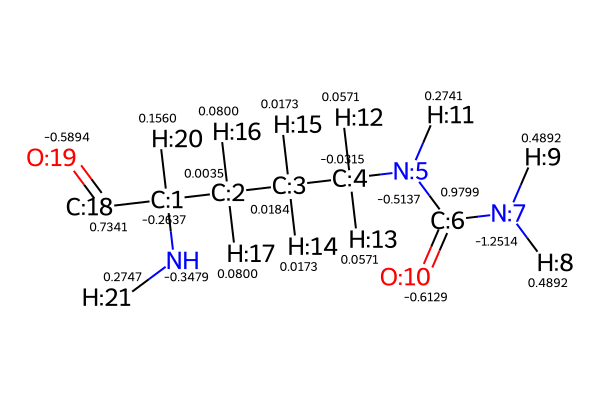

In [245]:
print(pt.calculate_true_sum(monomer_charge_list), monomer_charge_list ,sep='\n')
pt.draw_mol_with_atom_index(monomer_chem['R_CIT'], charge_list=monomer_charge_list)


-1.67E-16
[-1.2513543090974146  0.9799111137760017 -0.6129432395073339
 -0.5136840749984252 -0.0315225098772255  0.0183936598061241
  0.0034561318259698 -0.2637              0.7341
 -0.7884665976428863 -0.5894             -0.3479
  0.4892222254922636  0.4892222254922636  0.2741052739000144
  0.0571193676980222  0.0571193676980222  0.0173052717439586
  0.0173052717439586  0.0800093743943815  0.0800093743943815
  0.156               0.2747              0.380948040374833
  0.2900440327830904]


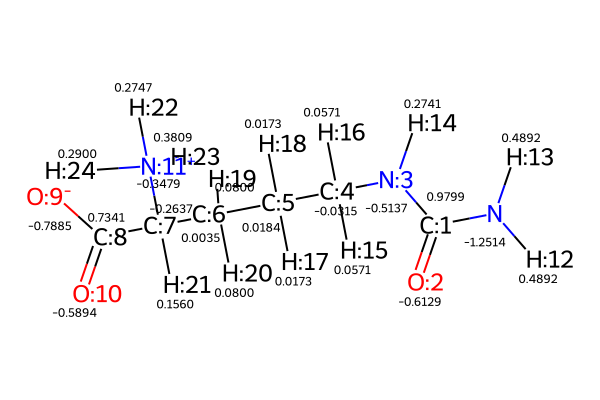

In [248]:
print(pt.calculate_true_sum(job.molecules[0].charges), job.molecules[0].charges ,sep='\n')
pt.draw_mol_with_atom_index(trimers_chem['R_CIT'], charge_list=job.molecules[0].charges)


0.1174
[-0.3479 -0.2637  0.0035  0.0184 -0.0315 -0.5137  0.9799 -1.2514  0.4892
  0.4892 -0.6129  0.2741  0.0571  0.0571  0.0173  0.0173  0.08    0.08
  0.7341 -0.5894  0.156   0.2747]


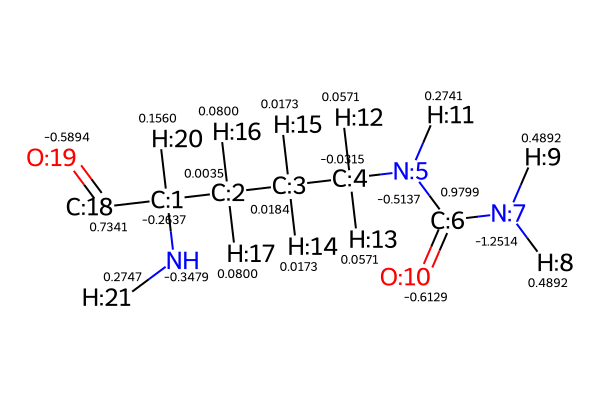

In [249]:
print(pt.calculate_true_sum(monomer_charge_list), monomer_charge_list ,sep='\n')
pt.draw_mol_with_atom_index(monomer_chem['R_CIT'], charge_list=monomer_charge_list)


In [203]:
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = (1200, 600)

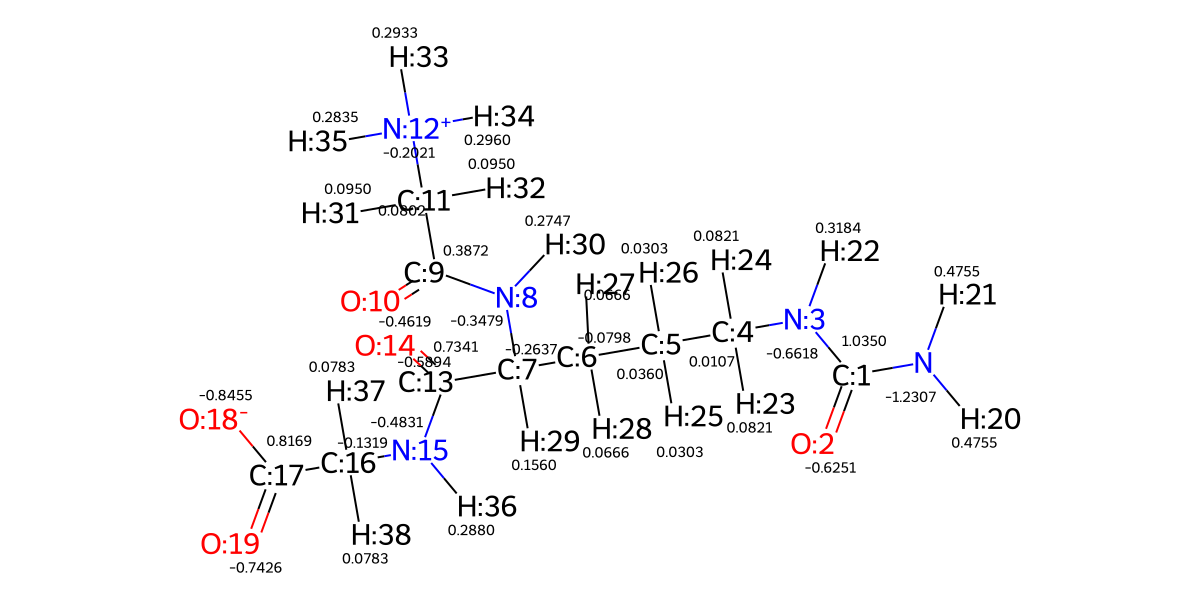

In [86]:
pt.draw_mol_with_atom_index(trimers_chem[param_mol_name], charge_list = job.molecules[0].charges, size=(1200,600))
# pt.draw_mol_with_atom_index(match_dict['substructure'][param_mol_name], charge_list = monomer_charge_list)

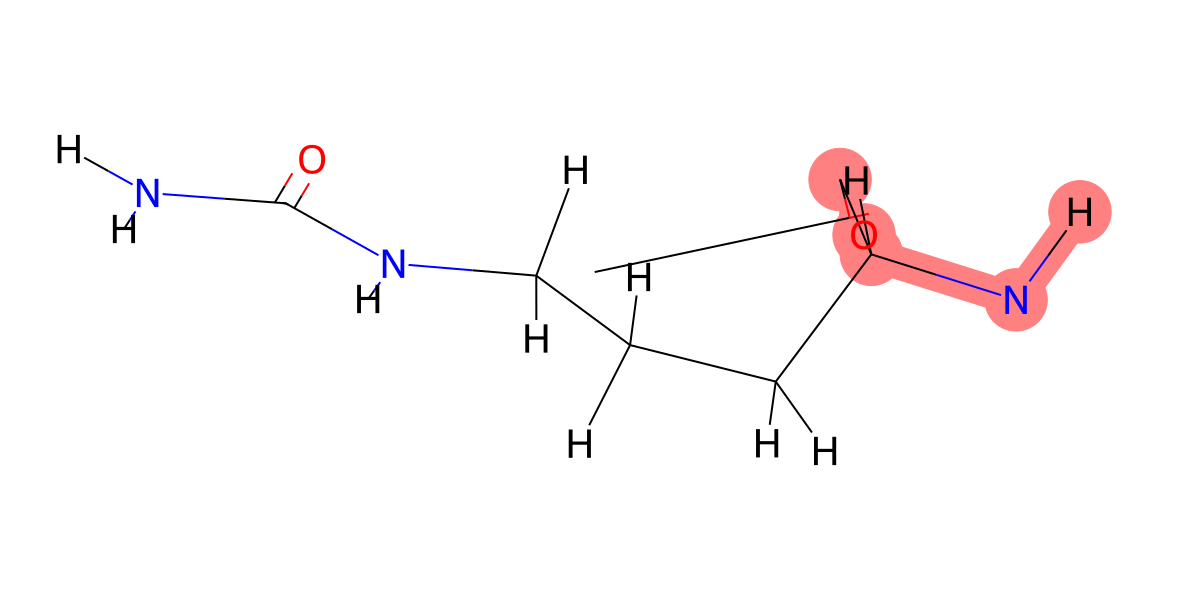

In [209]:
match_dict['substructure']['GRG_CIT']

In [19]:
print(pt.calculate_true_sum(monomer_charge_list), monomer_charge_list ,sep='\n')

-1.0000
[-1.2866  1.0232 -0.5923 -0.5637 -0.0571  0.045  -0.3981 -0.3068  0.8557
 -0.8266 -0.8266 -0.3479  0.2764  0.1447  0.1569  0.1569  0.0835  0.0835
  0.0693  0.0693  0.2609  0.4902  0.4902]


In [18]:
# monomer_charge_list[0]= -1.2866

## Сохранение масcива зарядов

In [16]:
# param_mol_name = "CR_CIT"

In [15]:
# !pwd

/home/_shared/_projects/2022_md_FRET_nv/param_R_CIT


In [ ]:
print(param_mol_name)

In [22]:
np.save(f'Charge_list/{param_mol_name}_done.npy', monomer_charge_list)


GR_CIT


In [17]:
np.load(f'Charge_list/{param_mol_name}_done.npy')

array([-1.2866,  1.0232, -0.5923, -0.5637, -0.0571,  0.045 , -0.3981,
       -0.3068,  0.8557, -0.8266, -0.8266, -0.3479,  0.2764,  0.1447,
        0.1569,  0.1569,  0.0835,  0.0835,  0.0693,  0.0693,  0.2609,
        0.4902,  0.4902])

In [ ]:
monomer_chem['R_CIT'].GetNumAtoms

In [15]:
type(sub_chem)

rdkit.Chem.rdchem.Mol

In [14]:
sub_chem = match_dict['substructure']['GRG_CIT']

In [16]:
mol_file_path = 'moleculse/substructure/R_CIT.mol'

In [ ]:
def save_chem_to_smiles(rdkit_mol, path):
    path_dir = path.rsplit('/', 1)
    if len(path_dir) > 1:
        os.makedirs(path_dir[0], exist_ok=True) 
    smiles_string = Chem.MolToSmiles(rdkit_mol)
    with open(f"{path}.smiles", "w") as file:
        file.write(smiles_string)

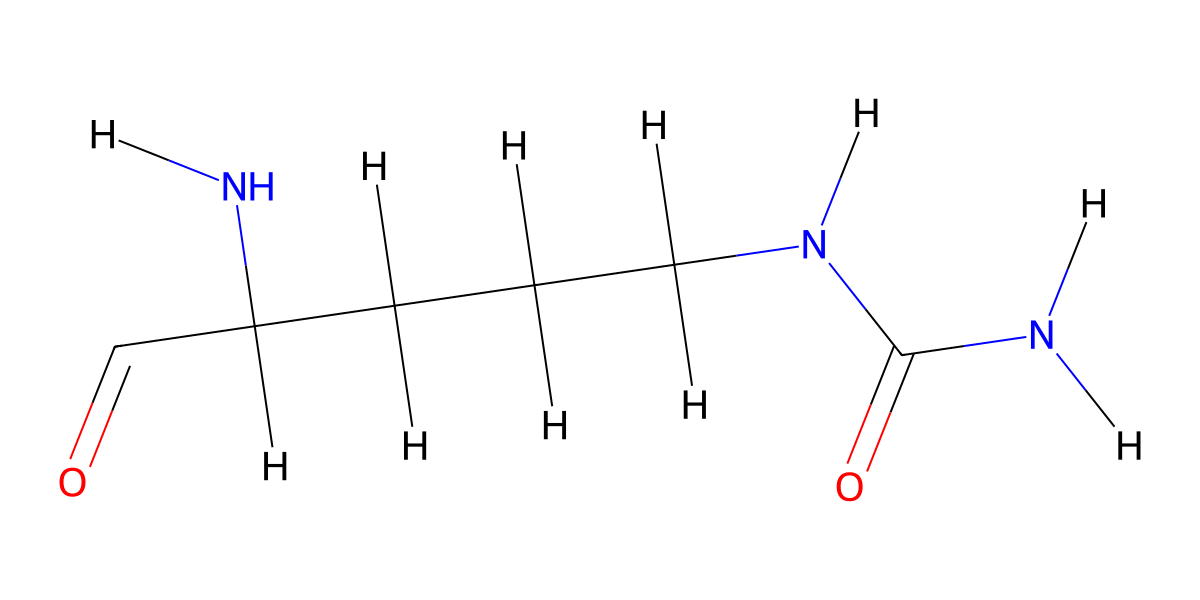

In [18]:
Chem.MolFromMolFile('moleculse/substructure/R_CIT.mol', removeHs=False)

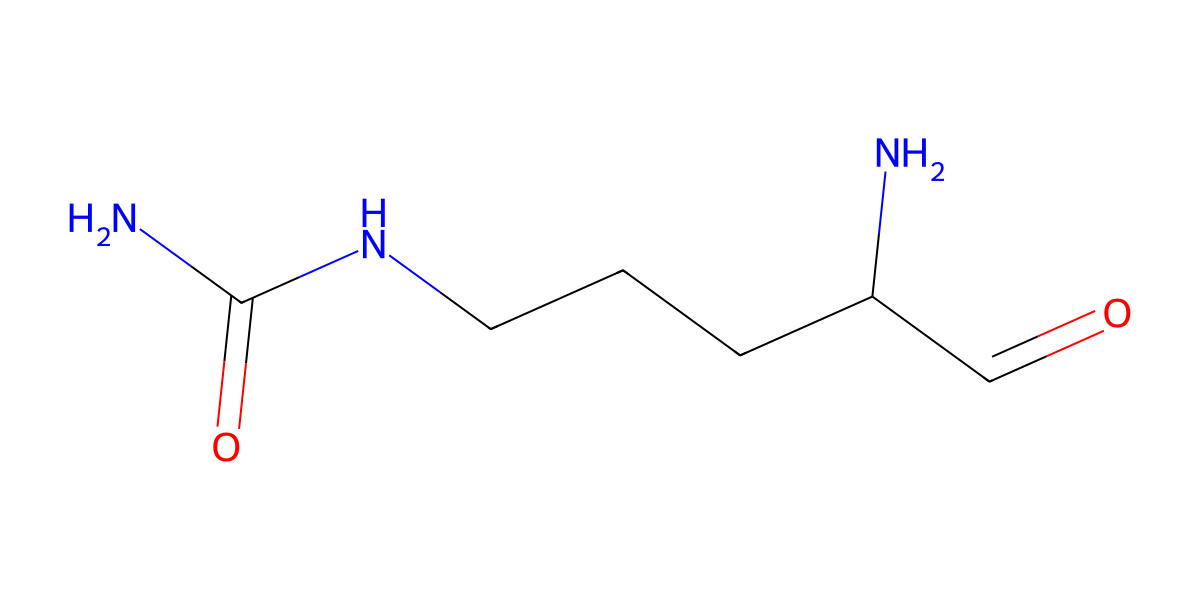

In [10]:
r_cit_smi = pt.read_file('moleculse/substructure/R_CIT.smiles')
Chem.MolFromSmiles(r_cit_smi['R_CIT'])
# dict_chem = pt.smi_to_chem(r_cit_smi )
# dict_chem['R_CIT']

In [11]:
r_cit_smi

{'R_CIT': '[N]([C](=[O])[N]([C]([C]([C]([C]([CH]=[O])([NH][H])[H])([H])[H])([H])[H])([H])[H])[H])([H])[H]'}

In [55]:
# import json
# with open('Charge_list/RA_CIT_done.json', 'w') as convert_file:
#      convert_file.write(json.dumps(monomer_charge_list))

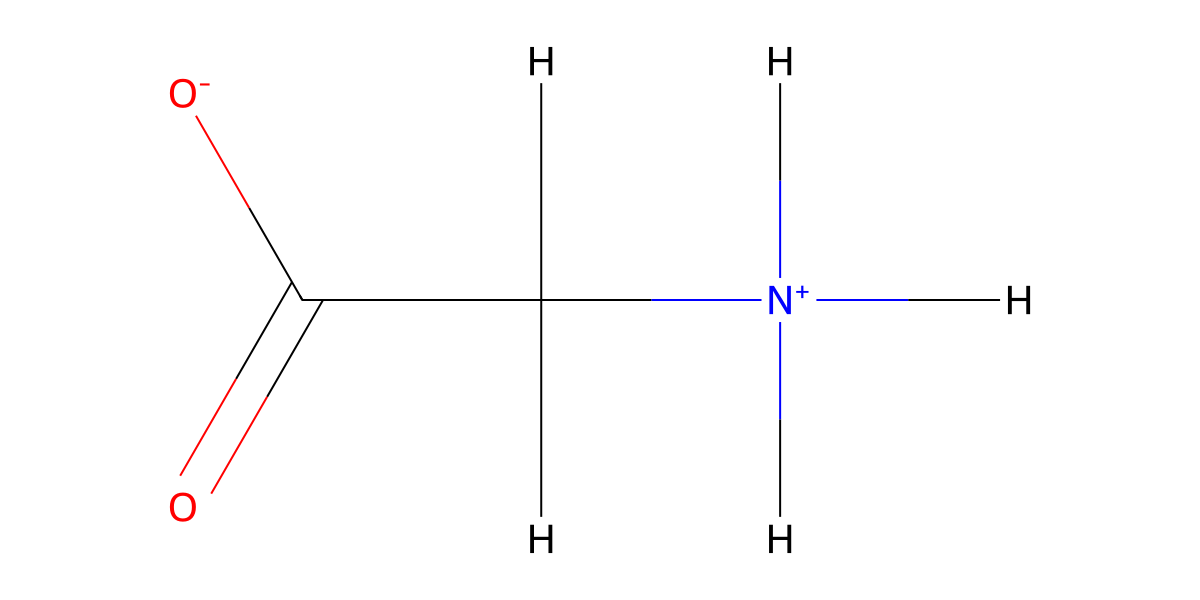

In [83]:
base = pt.read_file('AA_base.smiles')
base = Chem.MolFromSmiles(base['AA_base'], )
base = Chem.AddHs(base)
base

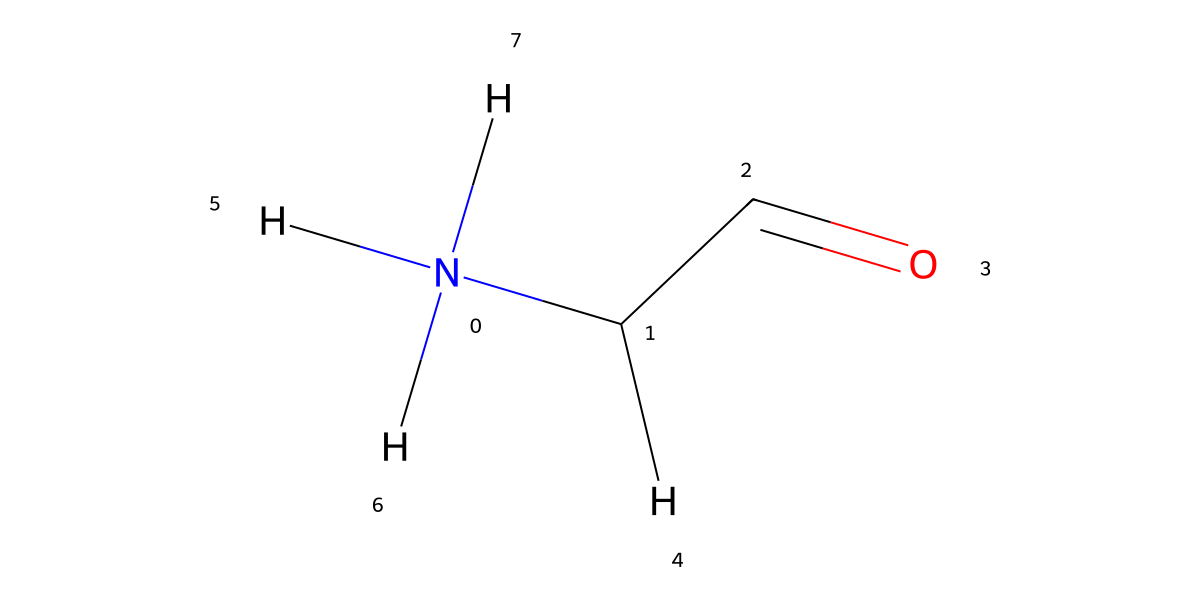

In [90]:
res = rdFMCS.FindMCS((sub_chem, base))
mcs_smarts = res.smartsString
substructure = Chem.MolFromSmarts(res.smartsString)
IPythonConsole.drawOptions.addAtomIndices = True
substructure

In [94]:
# backbone = sub_chem.GetSubstructMatches(substructure)
backbone = base.GetSubstructMatches(substructure)
backbone

((0, 1, 2, 4, 8, 5, 6, 7), (0, 1, 2, 4, 9, 5, 6, 7))

In [89]:
for atoms in backbone:
    a = m.GetAtomWithIdx(atoms[2])
    info = Chem.AtomPDBResidueInfo()
    info.SetName(" CA ") #spaces are important
    a.SetMonomerInfo(info)

((10, 7, 8, 9, 14, 11, 12, 13),)

In [83]:
def round_and_adjust(array, target_sum, precision=4):
    # Округление чисел массива до задданного порядка precision
    rounded_array = np.round(array, precision)
    
    # Находим разницу между целевой суммой и суммой округленных значений
    initial_sum = np.sum(rounded_array)
    diff = target_sum - initial_sum
    
    # Ищем уникальные значения с точностью более чем 4 знака после запятой
    unique_values, counts = np.unique(array, return_counts=True)
    eligible_indices = []
    for i, val in enumerate(array):
        # Проверка количества знаков после запятой
        decimal_part = str(val).split('.')[1]
        if len(decimal_part) > precision:
            # Проверка, что значение уникально
            index_in_unique = np.where(unique_values == val)[0][0]
            if counts[index_in_unique] == 1:
                eligible_indices.append(i)
                
    # Распределяем ошибку только между подходящими элементами
    if eligible_indices:
        correction_per_value = diff / len(eligible_indices)
        print(correction_per_value)
        for i in eligible_indices:
            rounded_array[i] += correction_per_value
    else:
        print('Не удалось выбрать заряды между которыми расперделелить сумму ошибки')
    
    # Финальная корректировка, если требуется
    final_sum = np.sum(rounded_array)
    if final_sum != target_sum:
        adjustment = target_sum - final_sum
        rounded_array[eligible_indices[-1]] += adjustment

    return rounded_array

In [84]:
monomer_charge_list
target_sum = 1.0000
adjusted_values = round_and_adjust(monomer_charge_list, target_sum, precision=4)
print(adjusted_values)
print(sum(adjusted_values))

-2.4999999999997247e-05
[-1.164725            0.9509749999999999 -0.624025
 -0.5551250000000001  0.040575            0.027475
 -0.652725           -0.0223              0.7214
 -0.6013              0.1305              0.2083
  0.2083              0.2083              0.1242
  0.2668              0.2668              0.0626
  0.0626              0.0587              0.0587
  0.2815750000000005  0.4712              0.4712            ]
1.0000000000000002


In [61]:
dec_round_list = []
for i in dec_list:
    dec_round_list.append(i.quantize(Decimal('1.0000'), ROUND_FLOOR))
sum(np.array(dec_round_list))

Decimal('0.9991')

In [16]:
charge_array = np.array(monomer_charge_list)
sum(charge_array.round(4))

1.0001999999999998

In [22]:
charge_array = charge_array.astype('float128') # longdouble
sum(charge_array.round(4).astype('float64')),

(1.0001999999999998,)

In [118]:
monomer_chem

{'R_CIT': <rdkit.Chem.rdchem.Mol at 0x7fe58297bee0>}

In [40]:
job

Job(molecules=[Molecule(name=C8H16N4O4, charge=0) with 2 conformers], qm_optimization_options=QMGeometryOptimizationOptions(method='hf', basis='6-31g*', pcm_options=None, driver='gradient', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, keywords={}, g_convergence='gau_tight', max_iter=200, full_hess_every=10, jobname='optimization'), qm_esp_options=QMEnergyOptions(method='hf', basis='6-31g*', pcm_options=None, driver='energy', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, keywords={}, jobname='single_point'), grid_options=GridOptions(grid_rmin=0, grid_rmax=-1, use_radii='msk', vdw_radii={}, vdw_scale_factors=[1.4, 1.6, 1.8, 2.0], vdw_point_density=1.0), resp_options=RespOptions(restraint_slope=0.1, restrained_fit=True, exclude_hydrogens=True, convergence_tolerance=1e-06, max_iter=500, restraint_height_stage_1=0.0005, restraint_height_stage_2=0.001, stage_2=True), charge_constraints=ChargeConstraintOptions(charge_sum_constraints=[

### Просмотр сгенерированных коформеров 

In [51]:
def show_conformer( conformer_index):
    return job.molecules[0].conformers[conformer_index].qcmol
n = len(job.molecules[0].conformers) -1
view = interact(show_conformer, conformer_index=(0,n,1) )


interactive(children=(IntSlider(value=0, description='conformer_index', max=1), Output()), _dom_classes=('widg…

In [47]:
len(job.molecules[0].conformers) - 1

1

In [10]:
job.molecules[0].conformers[1].qcmol

NGLWidget()

In [8]:
xyz_array = job.molecules[0].conformer_generation_options.generate_coordinates(job.molecules[0].conformers[0].qcmol)

In [7]:
name_of_system = 'R_CIT'
pt.run_psiresp_safely(RESP_list, name_of_system)
pt.show_list_of_conf(f'{name_of_system}/optimization/', True)

Новое имя директории: R_CIT


generate-conformers: 100%|██████████| 3/3 [18:13<00:00, 364.59s/it]

SystemExit: Exiting to allow running QM computations; commands are in R_CIT/optimization/run_optimization.sh
Колличество конформеров: 10
C10H19N5O5_c19a4abd2549d770a6476b7a4e6ba8d6622c5980_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_4c54f2e0ab33b183f1367553e34b7d21fe9476ca_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_cd05f07f8e3f62c2a410b3081c2859d95a172c4e_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_f9fc58e3bf7c4e8bce95c48dad2d0c95e250429c_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_7e56d83d65dc5cb9796e94ee01d4b0dccfa84ca8_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_d7e7a9c69457cca6ef94b9e06237b364fe9d00d8_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_b0f7179eadd043fa4b60939e3b479d24188028d4_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_667c46b5a2bdfa9a29e24776b7ed7ba9e63870ea_3295dc7332cc740b0c698580ccc3dd1759e5b5fe.msgpack
C10H19N5O5_b0f8c3c682e4c266cbfb42820184ef23346ec83b_329

In [9]:
xyz_array

array([[[ 4.638295975432047 ,  3.9979149150440594,  0.132963883106045 ],
        [ 4.163683867722276 ,  3.3523828797917905, -1.0443398079096096],
        [ 4.869886430087356 ,  3.35018956261719  , -2.078783072412024 ],
        ...,
        [-4.406220898291307 , -2.76868857640632  ,  3.415886587017536 ],
        [-3.0038195328187918, -2.0315050244527577,  4.30820821334429  ],
        [-4.84306283978855  , -4.047685853986545 ,  6.867594713579183 ]],

       [[-4.916565418996202 , -3.989208249721407 , -0.8019791212129611],
        [-3.661863325225191 , -3.3384817293860003, -0.7686167405117216],
        [-3.616634163710693 , -2.1428364105300406, -1.1900242665846927],
        ...,
        [ 3.695517014124607 ,  4.044229674033296 , -2.8910427960060767],
        [ 4.647555614431996 ,  2.5450768017348   , -3.1042664311763617],
        [ 2.6442627558296214,  3.0417673491440365, -6.25472332962794  ]],

       [[ 2.3868967062122266,  5.65331350792234  , -2.45560150710838  ],
        [ 1.771323184